# Homework 2 solution (Part 2)

Tasks in this part of the homework:

* Write a diversity evaluator based on the Evaluator framework for Surprise that we built in Lab 2. You will make use of the "tag genome" data from MovieLens.
* Write a novelty / surprisal evaluator based on the Evaluator framework for Surprise
* Using the extended test data created in Part 1,
    * Using this test data, generate recommendations, create recommendation lists (using the `UserPrediction` code), and evaluate these recommendations using 5-fold cross-validation as follows:
    * `BaselineOnly` algorithm
    * `SVD` (biased matrix factorization) with three different numbers of factors (25, 50, 100) and three different regularization `reg_all` values (0.1, 0.01, 0.001). 
* Display your results in scatterplots of diversity vs ndcg and surprisal vs ndcg.

The 5-fold cross-validation will take a while to run. Be sure to leave plenty of time and test your code on small subsets of the data before investing in length computing runs. Also, it might be a good idea to save intermediate results along the way so that if it crashes along the way, you don't have to re-compute everything. 


## Imports

In [ ]:
import sys
!{sys.executable} -m pip install surprise
#pip install icecream

In [93]:
import surprise
from surprise.prediction_algorithms.predictions import Prediction
from surprise import Dataset, BaselineOnly, Reader, SVD
from surprise.model_selection import PredefinedKFold

from collections import defaultdict
from itertools import combinations, product
import pandas as pd
import numpy as np
import pickle
from abc import ABC, abstractmethod
import seaborn as sb

## From class

### Encapsulating recommendation lists

In [4]:
class UserRecommendations:
    
    def __init__(self):
        self.recs = []
        
    def add_entry(self, entry):
        self.recs.append(entry)
        
    def select_top(self, k):
        self.recs = sorted(self.recs, key=lambda entry: entry.est, reverse=True)
        if len(self.recs) > k:
            self.recs = self.recs[0:k]
            
        
class TestRecommendations:
    
    def __init__(self):
        self.test_recs = defaultdict(UserRecommendations)
        
    def setup(self, preds, k):
        for entry in preds:
            user = entry.uid
            self.test_recs[user].add_entry(entry)
                   
        for user in self.test_recs.keys():
            self.test_recs[user].select_top(k)
            
    def iter_recs(self):
        for user in self.test_recs.keys():
            yield (user, self.test_recs[user].recs)


### Evaluator abstract classes

In [5]:
class Evaluator(ABC):
    
    def __init__(self):
        self.results_table = None
        self.score = None
        
    def setup(self, trainset, testset):
        pass
    
    @abstractmethod
    def evaluate_user(self, user, user_recs):
        pass
    
    def evaluate(self, test_recs: TestRecommendations):
        scores = []
        self.results_table = {}
        for user, recs in test_recs.iter_recs():
            score = self.evaluate_user(user, recs)
            scores.append(score)
            self.results_table[user] = score
        self.score = np.mean(scores)
        
class ItemwiseEvaluator(Evaluator):
    
    def __init__(self):
        super().__init__()
    
    def evaluate_user(self, user, user_recs):
        return np.mean([self.evaluate_pred(rec) for rec in user_recs])
        
    @abstractmethod
    def evaluate_pred(self, pred: Prediction):
        pass
    
class ListwiseEvaluator(Evaluator):
    
    def __init__(self):
        super().__init__()
    
    @abstractmethod
    def evaluate_user(self, user, user_recs):
        pass

### NDCG

In [6]:
class NDCGEvaluator(ListwiseEvaluator):
    
    def __init__(self, threshold, k):
        super().__init__()
        self.rated_table = defaultdict(set)
        self.threshold = threshold
        self.idcg_table = {}
        self.log_table = {}
        self.list_len = k
    
    def setup(self, trainset, testset):
        for user, item, rating in testset:
            if float(rating) > self.threshold:
                self.rated_table[user].add(item)
        idcg = 0
        for i in range(0, self.list_len+1):
            self.idcg_table[i] = idcg
            rank_utility = 1 / np.log(i+2)
            self.log_table[i] = rank_utility
            idcg += rank_utility
            
    
    def evaluate_user(self, user, user_recs): 
        
        dcg = 0.0
        for i, pred in enumerate(user_recs):
            if pred.iid in self.rated_table[user]:
                dcg = self.log_table[i]
        
        idcg = 0
        if len(self.rated_table[user]) >= self.list_len:
               idcg = self.idcg_table[self.list_len]
        else:
               idcg = self.idcg_table[len(self.rated_table[user])]
            
        if idcg == 0:
            return 0
        return dcg/idcg
                

## Part 1: Novelty / Surprisal

Implement an evaluation metric/function for per-user novelty. This will be a sub-class of the ItemwiseEvaluator metric defined above and in lab. The metric should measure the average entropy of the recommendation list. Let $k$ be the total number of ratings in the dataset. Let $k_i$ be the total number of ratings in the dataset for item $i$. Let $\ell_u$ be the recommendation list for user $u$ consisting of some number of items. Novelty $\nu_u$ is defined as the (smoothed) total entropy of the list:

$\nu_u = - \sum_{i \in \ell_u} \frac{k_i+1}{k} {log \frac{k_i+1}{k}}$

### Hints:

* This is similar to PrecisionEvaluator from the Lab 2 extension.
* We are computing the average rather than the sum (the original definition of the surprisal metric) because averaging of the per-prediction scores is built into our evaluation method. If this bothers you, use the ListwiseEvalutor base class and just compute the sum without averaging.
* We are smoothing the feature count by adding one to all the counts. That means that an item that doesn't appear in the training set still has a count of 1 and so we don't have to worry about computing `log(0)` which is undefined.
* You can create a global table of entropy values to make this more efficient but make sure that you handle the case where the item doesn't appear in the training data. It should still have $1/k$ as its frequency.

In [141]:
class NoveltyEvaluator(ItemwiseEvaluator):
    
    def __init__(self):
        super().__init__()
        self.entropy_table = defaultdict(list)
        self.min_entropy = int

    
    def setup(self, trainset, testset):
        #count number of items in testset     
        denom = len(testset)
        self.min_entropy = -1/denom*np.log2(1/denom)
        for user, item, rating in testset:
            #count everytime an item has a rating in the tesset
            test_i = 0
            if item in testset:
                test_i +=1
            numer = test_i+1 
            
            entropy = -(numer/denom)*np.log2(numer/denom)
            self.entropy_table[item].append(entropy)
    
    def evaluate_pred(self, pred: Prediction):
        
        entropy_values = self.entropy_table[pred.iid]

        for entropy in entropy_values:
            if entropy is not None:
                return entropy
        return self.min_entropy
    
    

## Part 2: Diversity

Implement a pairwise cosine diversity evaluator. You will use the tag genome scores from the MovieLens dataset. This is a vector of ~1100 scores that associate a movie with different manually assigned tags. (Think of it as a crowd-sourced embedding.) The formula is 

$D = 1 - \frac{\sum_{i, j \in \ell; i \neq j}sim(i, j)}{|\{i, j \in \ell; i \neq j\}|}$

When $\ell$ is a recommendation list, and $sim$ is the cosine of the tag representations of movies $i$ and $j$. The denominator of the fraction is just the count of the number of pairs so that you can compute the average. 

Hints: 

* Use the `setup` method to load the `sample-genome-scores.csv` file and create a lookup table mapping movie ids to a list of relevance scores. Note that every movie has a score for every tag

* `itertools.combinations` is your friend.

In [126]:
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
#from icecream import ic

class PairwiseCosineDiversityEvaluator(ListwiseEvaluator):
    tag_data_path = 'Homework 2 data/sample-genome-scores.csv'
    
    def __init__(self):
        super().__init__()
        #self.table_of_sim = defaultdict(dict)
        
    def setup(self, trainset, testset):
        tags_df = pd.read_csv(PairwiseCosineDiversityEvaluator.tag_data_path)


    def tag_sim(self, tag1, tag2):
        return cosine_similarity([tag1], [tag2])

    def evaluate_user(self, user, user_recs):
        diversity = 0
        count=0
        sims_sum=0
        tag_combinations = combinations((pred.iid for pred in user_recs), 2)       
        for tag1, tag2 in tag_combinations:
            count +=1
            item_tags1 = tags_df[tags_df['movieId'] == int(tag1)]['relevance'].values
            item_tags2 = tags_df[tags_df['movieId'] == int(tag2)]['relevance'].values
            if item_tags1.size > 0 and item_tags2.size > 0:
                sim = self.tag_sim(item_tags1, item_tags2)
                sims_sum += float(sim)
                #ic(sims_sum)
        diversity = 1-(sims_sum/count)
        #ic(diversity)
                
                
        return diversity


In [13]:
folds_files = [(f'Homework 2 data/train-{i}.csv', f'Homework 2 data/test-{i}.csv') for i in (1, 2, 3, 4, 5)]
#folds_files = [('Homework 2 data/train-1.csv', 'Homework 2 data/test-1.csv')]

In [14]:
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)
data = Dataset.load_from_folds(folds_files, reader=reader)

## Part 4: BaselineOnly

Using the instance of the BaselineOnly algorithm defined below, evaluate nDCG, Surprisal and Diversity on all 5 folds of the data with a list size of 10.

Produce a box-plot showing the distribution of values of each of the metrics. See my example attached.

In [15]:
bsl_options = {
    "method": "sgd",
    "learning_rate": 0.001,
}
bsl = BaselineOnly(bsl_options=bsl_options)

In [ ]:
evals = pd.DataFrame(columns = ['Fold', 'NDCG', 'Novelty', 'Diversity'])

In [ ]:
pkf = PredefinedKFold()

fold = 0
for trainset, testset in pkf.split(data):
    fold += 1
    extended_test_data = pickle.load( open(f"extended_testset{fold}.p", "rb" ))
    

    # Create evaluators
    ndcg = NDCGEvaluator(2.5, 10)
    novelty = NoveltyEvaluator()
    diversity = PairwiseCosineDiversityEvaluator()
    ndcg.setup(trainset, testset)
    novelty.setup(trainset, testset)
    diversity.setup(trainset, testset)
    # Fit model and predict
    bsl.fit(trainset)
    preds = bsl.test(extended_test_data)
    # Setup TestRecommendations object
    trecs = TestRecommendations()
    trecs.setup(preds, k=10)
    # Evaluate
    ndcg.evaluate(trecs)
    novelty.evaluate(trecs)
    diversity.evaluate(trecs)
    # Print progress and save results
    evals.loc[len(eval.index)]=[1, ndcg.score, novelty.score, diversity.score]
    print(ndcg.score, novelty.score, diversity.score)
    

Estimating biases using sgd...


In [137]:
evals

,Fold,NDCG,Novelty,Diversity
0,1.0,0.024841,0.003018,0.284325


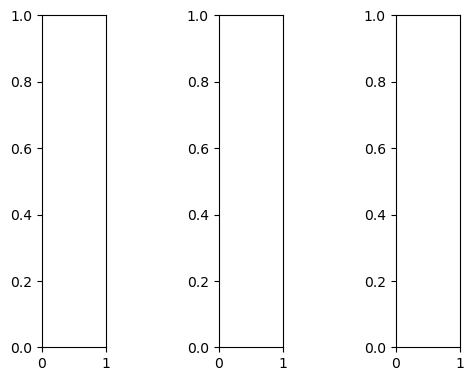

In [2]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(6,5))

fig.tight_layout(pad=5.0)

# plots here


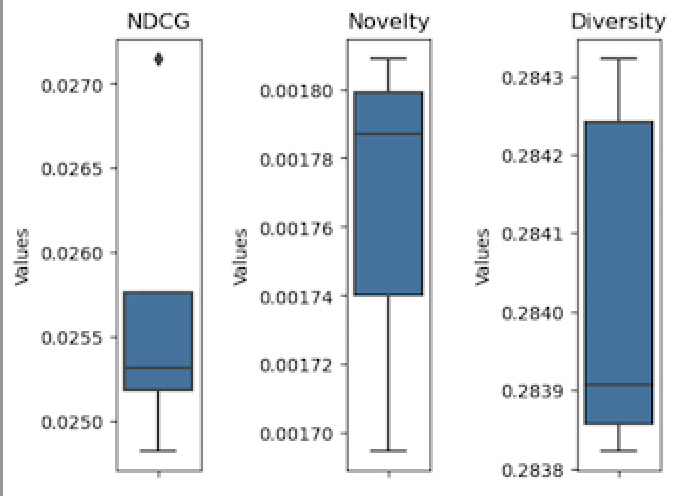

## Part 4: Evaluate SVD

* Explore different numbers of factors (25, 50, 100).
* Explore different regularization (reg_all) 0.02, 0.05, 0.1

Note that you will not be able to use the built-in model selection tools in Surprise because it doesn't support our list-wise evaluation model. Use the same evaluation as above: surprisal, ndcg, and diversity.

First define a function to process a single fold of the data.

In [ ]:
def process_fold(fold, trainset, testset, algo):
    print('Processing split...')
    extended_test_data = pickle.load( open(f"extended_testset{fold}.p", "rb" ))
    # Create and setup evaluators
    ndcg = NDCGEvaluator(2.5, 10)
    ndcg.setup(trainset, testset)
    novelty.setup(trainset, testset)
    diversity.setup(trainset, testset)
    # Fit model and predict
    algo.fit(trainset)
    preds = algo.test(sampled_test)
    print('Recommendations generated...')
    # Setup TestRecommendations object
    trecs = TestRecommendations()
    trecs.setup(preds, k=10)
    # Evaluate
    novelty.evaluate(trecs)
    diversity.evaluate(trecs)
    ndcg.evaluate(trecs)
    # Print progress and save results
    
    return (ndcg.score, novelty.score, diversity.score)

    
     
    
    
    
  
    
   
    


Using this function, go through all of the parameter configurations and all the folds and compute the predictions. Average over the folds to get a single score for each configuration of # factors and regularization weight. 

Hints
- `itertools.product` is your friend
- I strongly recommend saving (via pickle) the results so far at each iteration. That way if the process dies, you don't lose the work you've done.
- This process took about 3 hours on CSEL when I ran it.

In [ ]:
pkf = PredefinedKFold()

config_factors = [25, 50, 100]
config_reg = [0.02, 0.05, 0.1]

results = []

for factors in config_factors:
    for reg in config_reg:
        for trainset, testset in pkf.split(data):
            exp_evals = []
            algo = SVD(n_factors=factors, reg_all=reg)
            ndcg, novelty, diversity = process_fold(trainset, testset, algo)

            print(f'Factors {factors} Novelty {novelty} nDCG {ndcg} Diversity {diversity}')
            results.append({'factors': factors, 'precision': prec, 'ndcg': ndcg})

## Interpretation

Create a scatterplot of ndcg@10 vs diversity (averaged over the 5 folds) for the different algorithm settings. If you're using `seaborn`, which I recommend, you can use `hue` to represent the regularization value and `size` to represent the number of factors.

Question: The larger number of factors and the smaller the regularization coefficient, the more complex the model. Do you think that the model is overfitting for the extreme values of these (100 factors, 0.02 regularization)? Explain and how does the plot demonstrate this?

Answer: _Answer here_

Create a similar scatterplot with novelty and diversity. 

Question: Note that the smaller the Novelty value, the more low probability items are in the recommendation list. In general, do lists with higher diversity have more of these low probability items? How do you know? Are there exceptions to this trend?

Answer: _Answer here_

Question: If you were trying to tune this algorithm further for this dataset, what would you try next and why (assume that you are looking for a good balance of diversity and ranking accuracy)? (There is no right answer to this question. I'm interested in your thought process, so be clear about your reasoning!)

Answer: _Answer here_